In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import matplotlib.ticker as mticker
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.tree import plot_tree
from itertools import product

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [4]:
# define three-year mortalitty status
df_train.loc[:,'MORTSTAT3Y'] = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 1, 0)
df_test.loc[:,'MORTSTAT3Y'] = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 1, 0)

In [5]:
# select features and target
X_train_3y = df_train.drop(columns=['MORTSTAT3Y', 'TIMETOEVENT', 'MORTSTAT'])
y_train_3y = df_train['MORTSTAT3Y']

X_test_3y = df_test.drop(columns=['MORTSTAT3Y', 'TIMETOEVENT', 'MORTSTAT'])
y_test_3y = df_test['MORTSTAT3Y']

In [6]:
# DecisionTreeClassifier

In [7]:
# DTC1

In [8]:
param_grid = {'max_depth': [3, 5, 10, 15]}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion='log_loss'), param_grid, cv=4, scoring='neg_log_loss')
grid_search.fit(X_train_3y, y_train_3y)

print(grid_search.best_params_)

{'max_depth': 3}


In [9]:
dtc1 = DecisionTreeClassifier(criterion='log_loss', max_depth=3)

# train
start_time = time.time()
dtc1.fit(X_train_3y, y_train_3y)
print(f"Training Time: {time.time() - start_time:.4f} seconds")

Training Time: 0.1522 seconds


In [10]:
# get predicted probabilities
y_pred_proba_train_3y = dtc1.predict_proba(X_train_3y)[:, 1]
y_pred_proba_test_3y = dtc1.predict_proba(X_test_3y)[:, 1]

# compute Log Loss
logloss_train_3y = log_loss(y_train_3y, y_pred_proba_train_3y)
logloss_test_3y = log_loss(y_test_3y, y_pred_proba_test_3y)

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, y_pred_proba_train_3y)
bs_test_3y = brier_score_loss(y_test_3y, y_pred_proba_test_3y)

# c-index
c_is = concordance_index(y_pred_proba_train_3y, y_train_3y)

print(f'Log Loss is: {logloss_train_3y:.4f}')
print(f'Log Loss os: {logloss_test_3y:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1238
Log Loss os: 0.1221
BS is: 0.0317
BS os: 0.0312
C is: 0.5321


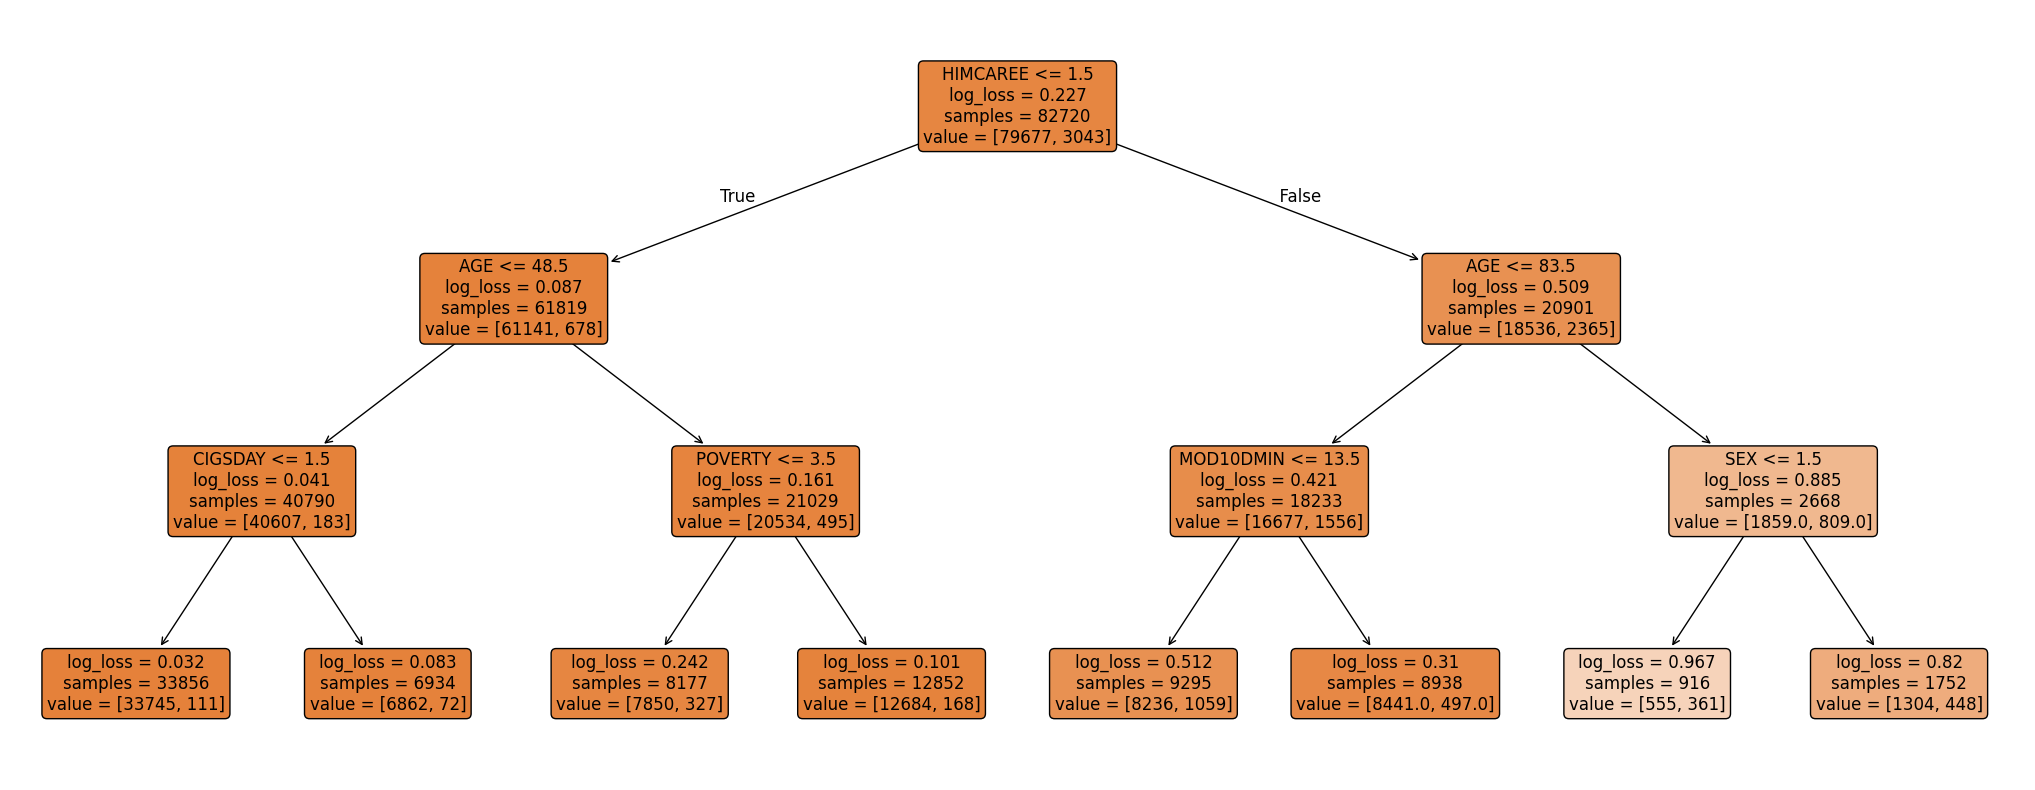

In [11]:
plt.figure(figsize=(26, 10))
plot_tree(dtc1, filled=True,feature_names=X_train_3y.columns, 
          rounded=True, proportion=False, max_depth=3,fontsize=12)

plt.savefig(f'decision_tree_plot.png', format='png', dpi=300)
plt.show()

In [12]:
# DTC2

In [13]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_leaf_nodes': [10, 15, 20, 25, 30, 40],
              'min_samples_leaf': [100, 300, 500, 600, 700]}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion='log_loss'), param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(X_train_3y, y_train_3y)

print(grid_search.best_params_)

{'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 100}


In [14]:
dtc2 = DecisionTreeClassifier(criterion='log_loss', max_depth=10, max_leaf_nodes= 30, min_samples_leaf= 100)

# train
start_time = time.time()
dtc2.fit(X_train_3y, y_train_3y)
print(f"Training Time: {time.time() - start_time:.4f} seconds")

Training Time: 0.4071 seconds


In [15]:
# get predicted probabilities
y_pred_proba_train_3y = dtc2.predict_proba(X_train_3y)[:, 1]
y_pred_proba_test_3y = dtc2.predict_proba(X_test_3y)[:, 1]

# compute Log Loss
logloss_train_3y = log_loss(y_train_3y, y_pred_proba_train_3y)
logloss_test_3y = log_loss(y_test_3y, y_pred_proba_test_3y)

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, y_pred_proba_train_3y)
bs_test_3y = brier_score_loss(y_test_3y, y_pred_proba_test_3y)

# c-index
c_is = concordance_index(y_pred_proba_train_3y, y_train_3y)

print(f'Log Loss is: {logloss_train_3y:.4f}')
print(f'Log Loss os: {logloss_test_3y:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1183
Log Loss os: 0.1171
BS is: 0.0307
BS os: 0.0304
C is: 0.5300


In [16]:
# DTC3

In [17]:
param_grid = {'max_depth': [7, 8, 9, 10, 11, 12],
              'max_leaf_nodes': [26, 28, 30, 32, 34],
              'min_samples_leaf': [50, 80, 100, 120, 150, 180, 200, 250]}

# for tracking best parameters and best score (log-loss)
best_params_ll = None
best_score_ll = np.inf  
# for tracking best parameters and best score (brier score)
best_params_bs = None
best_score_bs = np.inf  

# iterate over all combinations of parameters
for max_depth, max_leaf_nodes, min_samples_leaf in product(
        param_grid['max_depth'], param_grid['max_leaf_nodes'], param_grid['min_samples_leaf']):
    
    # train model on training set
    model = DecisionTreeClassifier(criterion='log_loss', max_depth=max_depth, 
                                                         max_leaf_nodes=max_leaf_nodes, 
                                                         min_samples_leaf=min_samples_leaf)
    model.fit(X_train_3y, y_train_3y)
    
    # evaluate on test set 
    y_pred_proba_test_3y = model.predict_proba(X_test_3y)[:, 1]
    score_ll = log_loss(y_test_3y, y_pred_proba_test_3y)  
    score_bs = brier_score_loss(y_test_3y, y_pred_proba_test_3y) 
    
    # update best parameters if the current model is better
    if score_ll < best_score_ll:
        best_score_ll = score_ll
        best_params_ll = {'max_depth': max_depth,'max_leaf_nodes': max_leaf_nodes,'min_samples_leaf': min_samples_leaf}
    # update best parameters if the current model is better
    if score_bs < best_score_bs:
        best_score_bs = score_bs
        best_params_bs = {'max_depth': max_depth,'max_leaf_nodes': max_leaf_nodes,'min_samples_leaf': min_samples_leaf}    
    

print("best parameters in terms of LL_os:", best_params_ll)
print("best LL_os:", best_score_ll)
print("\nbest parameters in terms of BS_os:", best_params_bs)
print("best BS_os:", best_score_bs)

best parameters in terms of LL_os: {'max_depth': 7, 'max_leaf_nodes': 32, 'min_samples_leaf': 50}
best LL_os: 0.11699098268693618

best parameters in terms of BS_os: {'max_depth': 7, 'max_leaf_nodes': 32, 'min_samples_leaf': 50}
best BS_os: 0.030349172902306248


In [18]:
dtc3 = DecisionTreeClassifier(criterion='log_loss', max_depth=7, max_leaf_nodes= 32, min_samples_leaf= 50)

# train
start_time = time.time()
dtc3.fit(X_train_3y, y_train_3y)
print(f"Training Time: {time.time() - start_time:.4f} seconds")

Training Time: 0.2806 seconds


In [19]:
# get predicted probabilities
y_pred_proba_train_3y = dtc3.predict_proba(X_train_3y)[:, 1]
y_pred_proba_test_3y = dtc3.predict_proba(X_test_3y)[:, 1]

# compute Log Loss
logloss_train_3y = log_loss(y_train_3y, y_pred_proba_train_3y)
logloss_test_3y = log_loss(y_test_3y, y_pred_proba_test_3y)

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, y_pred_proba_train_3y)
bs_test_3y = brier_score_loss(y_test_3y, y_pred_proba_test_3y)

# c-index
c_is = concordance_index(y_pred_proba_train_3y, y_train_3y)

print(f'Log Loss is: {logloss_train_3y:.4f}')
print(f'Log Loss os: {logloss_test_3y:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')
print(f'C is: {c_is:.4f}')

Log Loss is: 0.1179
Log Loss os: 0.1170
BS is: 0.0306
BS os: 0.0303
C is: 0.5300
